In [1]:
import pandas as pd
import numpy as np
import collections
import copy
import random
import re
import matplotlib.pyplot as plt
from nlp.utils import (
    plot_histogram,
    get_completetext,
    plot_wordcloud,
    print_statistics,
    groups_frequency_sort)
from nlp.text_statistics import (
    count_tokens,
    unique_tokens
)
from utils.read_files import (
    get_items)
from item.item_list import (
    ItemList,
    Item
)
from item.utils import get_tokens_set
import seaborn as sns

sns.set()

# Load price statistics

In [3]:
prices = pd.read_csv('../data/output/druid/cluster_prices_statistics_year.csv.zip', sep=';')
items = pd.read_csv("../data/output/druid/items_clusters_train.csv.zip", sep=';')

In [4]:
len(prices[['dsc_unidade_medida', 'cluster']].drop_duplicates())

288974

In [5]:
prices.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 951216 entries, 0 to 951215
Data columns (total 14 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   cluster             951216 non-null  object 
 1   dsc_unidade_medida  943459 non-null  object 
 2   ano                 951216 non-null  int64  
 3   mean                951216 non-null  float64
 4   count               951216 non-null  int64  
 5   max                 951216 non-null  float64
 6   min                 951216 non-null  float64
 7   median              951216 non-null  float64
 8   std                 560772 non-null  float64
 9   var                 560772 non-null  float64
 10  quantile_1          951216 non-null  float64
 11  quantile_3          951216 non-null  float64
 12  first_token         951024 non-null  object 
 13  outlier             951216 non-null  int64  
dtypes: float64(8), int64(3), object(3)
memory usage: 101.6+ MB


In [6]:
prices['first_token'] = prices['cluster'].str.split('_').str[0]

In [7]:
prices['std'] = prices['std'].fillna(0.0)
prices['var'] = prices['var'].fillna(0.0)
prices['mean'] = prices['mean'].fillna(1.0)

In [8]:
prices = prices.rename({'count': 'n_items'}, axis=1)

In [9]:
prices.head(50)

,cluster,dsc_unidade_medida,ano,mean,n_items,max,min,median,std,var,quantile_1,quantile_3,first_token
0,a100_0,tb,2017,56.000000,2,56.00,56.00,56.000,0.000000,0.000000,56.0000,56.0000,a100
1,a100_0,tubo,2015,60.100000,1,60.10,60.10,60.100,0.000000,0.000000,60.1000,60.1000,a100
2,a100_0,tubo,2017,32.200000,1,32.20,32.20,32.200,0.000000,0.000000,32.2000,32.2000,a100
3,a100_0,tubos,2017,50.550000,1,50.55,50.55,50.550,0.000000,0.000000,50.5500,50.5500,a100
4,a100_0,unidade,2015,52.704615,13,73.60,32.84,60.100,15.247907,232.498677,34.0400,60.1000,a100
5,a100_0,unidade,2016,47.452500,12,55.00,34.04,48.000,7.418752,55.037875,45.8475,55.0000,a100
6,a100_0,unidade,2017,52.747500,12,67.00,33.33,51.000,10.743947,115.432402,50.5500,63.0250,a100
7,a100_0,unidade,2018,40.409643,28,75.75,32.57,32.600,14.558290,211.943804,32.6000,38.2625,a100
8,a100_0,unidades,2015,40.480000,1,40.48,40.48,40.480,0.000000,0.000000,40.4800,40.4800,a100
9,a100_1,litro,2015,77.820000,4,82.04,73.60,77.820,4.872836,23.744533,73.6000,82.0400,a100


In [10]:
group = 'embreagem'

print(len(set(prices[prices.first_token == group]['cluster'])))
print(len((prices[prices.first_token == group].drop_duplicates(['cluster', 'dsc_unidade_medida']))[['cluster', 'dsc_unidade_medida']]))
print(len((prices[(prices.first_token == group) & (prices.n_items >= 20)].drop_duplicates(['cluster', 'dsc_unidade_medida']))[['cluster', 'dsc_unidade_medida']]))

28
132
23


In [12]:
group = 'embreagem'

print(len((prices[(prices.first_token == group)].drop_duplicates(['cluster', 'dsc_unidade_medida', 'ano']))[['cluster', 'dsc_unidade_medida', 'ano']]))
print(len((prices[(prices.first_token == group) & (prices.n_items >= 20)].drop_duplicates(['cluster', 'dsc_unidade_medida', 'ano']))[['cluster', 'dsc_unidade_medida', 'ano']]))

600
76


In [13]:
sum(list((prices[(prices.first_token == 'filtro')].drop_duplicates(['cluster', 'dsc_unidade_medida', 'ano']))['n_items']))

106588

In [14]:
items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10560288 entries, 0 to 10560287
Data columns (total 11 columns):
 #   Column              Dtype  
---  ------              -----  
 0   item_id             int64  
 1   seq_dim_licitacao   object 
 2   outlier             int64  
 3   cluster             object 
 4   dsc_unidade_medida  object 
 5   ano                 int64  
 6   description         object 
 7   original            object 
 8   areas               float64
 9   price               float64
 10  first_token         object 
dtypes: float64(2), int64(3), object(6)
memory usage: 886.3+ MB


In [20]:
# remove outliers
items = items[items.outlier != 1]

In [21]:
items['first_token'] = items['cluster'].str.split('_').str[0]

In [22]:
items.head(50)

,item_id,seq_dim_licitacao,outlier,cluster,dsc_unidade_medida,ano,description,original,areas,price,first_token
104,186,34761,0,rejuntamento_4,unidade,2014,rejuntamento c 1 kg,REJUNTAMENTO C/ 1KG.,NaN,3.3000,rejuntamento
105,387164,67677,0,rejuntamento_4,unidade,2014,rejuntamento com 1 kg,REJUNTAMENTO COM 01 KG,NaN,3.7667,rejuntamento
106,417226,107374,0,rejuntamento_4,unidade,2014,rejuntamento com 1 kg 100,100 REJUNTAMENTO COM 01 KG,NaN,5.4000,rejuntamento
107,479490,262607,0,rejuntamento_4,unidade,2014,rejuntamento quartz acrilico 1 kg,REJUNTAMENTO QUARTZ ACRILICO 1KG,NaN,0.2900,rejuntamento
108,552683,145993,0,rejuntamento_4,pacote,2014,rejuntamento tipo quartzolit c 1 kg,REJUNTAMENTO TIPO QUARTIZOLITE C/ 01 KG,NaN,3.3000,rejuntamento
109,669791,236616,0,rejuntamento_4,kg,2014,rejuntamento 1 kg,REJUNTAMENTO 1KG (140021005862649),NaN,3.1117,rejuntamento
110,713536,94491,0,rejuntamento_4,kg,2014,rejuntamento rejuntar 1 kg,REJUNTAMENTO/REJUNTE 1KG,NaN,4.6000,rejuntamento
111,1066151,107592,0,rejuntamento_4,kg,2014,rejuntamento branco pct 1 kg,REJUNTAMENTO BRANCO PCT 1KG,NaN,3.0300,rejuntamento
112,1378262,88870,0,rejuntamento_4,kg,2014,rejuntamento cor 1 kg,REJUNTAMENTO CORES 01 KG,NaN,3.8233,rejuntamento
113,1754344,4559,0,rejuntamento_4,pacote,2014,rejuntamento branco 1 kg,REJUNTAMENTO BRANCO DE 1 KG,NaN,4.2000,rejuntamento


# Termos: combustíveis

- gasolina
- álcool
- querosene
- óleo
- etanol
- diesel

In [23]:
combustiveis = ['gasolina', 'alcool', 'querosene', 'oleo', 'etanol', 'diesel']

# Termos: hospitais e Medicamentos

- álcool
- vitamina
- ácido
- lorazepam
- luva
- mascara
- algodão
- dipirona
- sabonete
- sabao
- pen
- atenolol
- alopurinol
- dea
- estetoscopio
- maca
- hospitalar
- reanimador
- esfigmomanômetro
- oxímetro
- camisola

In [24]:
hospitais_med = ['luva', 'mascara', 'acido', 'sabao', 'sabonete', 'algodao', 'alcool', 'vitamina', \
                 'lorazepam', 'dipirona','pen', 'atenolol', 'alopurinol', 'dea', 'estetoscopio', \
                 'maca', 'hospitalar', 'reanimador', 'esfignomanometro', 'oximetro', 'camisola']

# Termos: peças e serviços automotivos

- bateria
- filtro
- componentes
- capota
- macaco
- pastilha
- espelho
- antena
- carroceria
- lampada
- pneu
- freio
- parabrisa
- parachoque
- roda
- lataria
- calota
- ignicao

In [25]:
pecas_automotivos = ['macaco', 'pneu', 'freio', 'parabrisa', 'parachoque', 'roda', 'lampada', \
                     'bateria', 'pastilha', 'espelho', 'componentes', 'capota', 'antena', \
                     'carroceria', 'lataria', 'calota', 'ignicao', 'filtro', 'amortecedor', \
                     'coxim', 'radiador', 'virabrequim', 'correia', 'embreagem']

# Ano

In [26]:
clusters_years = prices[['dsc_unidade_medida', 'ano', 'first_token', 'cluster']]

In [27]:
clusters_years = clusters_years.drop_duplicates()

In [28]:
clusters_years

,dsc_unidade_medida,ano,first_token,cluster
0,unidade,2019,000uicomprevx4,000uicomprevx4
1,caixa,2019,00i,00i
2,pacote,2018,00i,00i
3,pacote,2019,00i,00i
4,unidade,2014,00i,00i
...,...,...,...,...
951211,metro quadrado,2014,zzzzzv,zzzzzv
951212,metro quadrado,2014,zzzzzw,zzzzzw
951213,metro quadrado,2014,zzzzzx,zzzzzx
951214,metro quadrado,2014,zzzzzy,zzzzzy


In [29]:
clusters_years = clusters_years.fillna('.')

## Número de anos

In [30]:
# group by "cluster" and "dsc_unidade_medida"
clusters_years['years'] = clusters_years.groupby(['cluster', 'dsc_unidade_medida'])['cluster'].transform('count')

In [31]:
clusters_years = clusters_years[['first_token', 'cluster', 'dsc_unidade_medida', 'years']]

In [32]:
# drop duplicates
clusters_years = clusters_years.drop_duplicates()

In [33]:
clusters_years.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 288974 entries, 0 to 951215
Data columns (total 4 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   first_token         288974 non-null  object
 1   cluster             288974 non-null  object
 2   dsc_unidade_medida  288974 non-null  object
 3   years               288974 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 11.0+ MB


In [34]:
set(clusters_years['years'])

{1, 2, 3, 4, 5, 6, 7}

## Número de itens

In [35]:
# group by "cluster" and "dsc_unidade_medida"
clusters_num_items = prices[['dsc_unidade_medida', 'cluster', 'first_token', 'ano', 'n_items']]

In [36]:
clusters_num_items = clusters_num_items.groupby(['cluster', 'dsc_unidade_medida'], as_index=False)['n_items'].sum()

In [37]:
clusters_num_items.head()

,cluster,dsc_unidade_medida,n_items
0,000uicomprevx4,unidade,1
1,00i,caixa,1
2,00i,pacote,2
3,00i,unidade,11
4,00m,caixa,1


In [38]:
clusters_years = pd.merge(clusters_years, clusters_num_items,  how='left', left_on=['cluster','dsc_unidade_medida'], right_on = ['cluster','dsc_unidade_medida'])

In [39]:
clusters_years = clusters_years.dropna()

In [40]:
clusters_years.head()

,first_token,cluster,dsc_unidade_medida,years,n_items
0,000uicomprevx4,000uicomprevx4,unidade,1,1.0
1,00i,00i,caixa,1,1.0
2,00i,00i,pacote,2,2.0
3,00i,00i,unidade,6,11.0
4,00m,00m,caixa,1,1.0


In [41]:
len(prices[prices.first_token == 'lataria'].drop_duplicates(['cluster', 'dsc_unidade_medida', 'ano']))

1

## Geral

In [42]:
def plot_countplot(dataframe, x):

    sns.set_style("white")

    fig, (axis1) = plt.subplots(figsize=(10,7))

    sns.countplot(x=x, data=dataframe, color='dodgerblue')

    axis1.set_xlabel("Nº de anos", fontsize=20, weight='bold')
    axis1.set_ylabel("Nº de grupos", fontsize=20, weight='bold')
    plt.grid(False)

    total = len(dataframe)
    for p in axis1.patches:
        height = p.get_height()
        axis1.text(p.get_x()+0.01, height+10, '(%d)'%(height), fontsize=15)
        axis1.text(p.get_x()+0.45, height+10, '%.2f%%'%(100*float(height)/total), fontsize=15)

    plt.yticks(fontsize=16)
    plt.xticks(fontsize=16)

    plt.show()
    plt.clf()

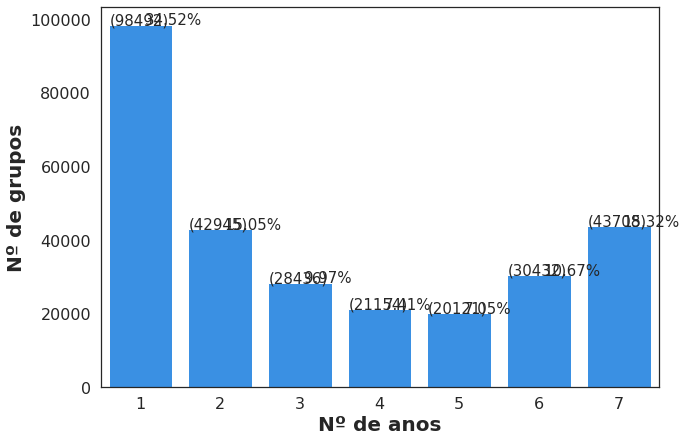

<Figure size 432x288 with 0 Axes>

In [43]:
plot_countplot(clusters_years, 'years')

In [44]:
total_items = sum(list(clusters_years['n_items']))

In [45]:
total_items

8452525.0

In [46]:
sum(list(clusters_years[clusters_years.years == 4]['n_items']))

175558.0

In [47]:
100*sum(list(clusters_years[clusters_years.years == 4]['n_items']))/total_items

2.076988828781932

## Combustíveis

In [48]:
combustiveis_years = clusters_years[clusters_years['first_token'].isin(combustiveis)]

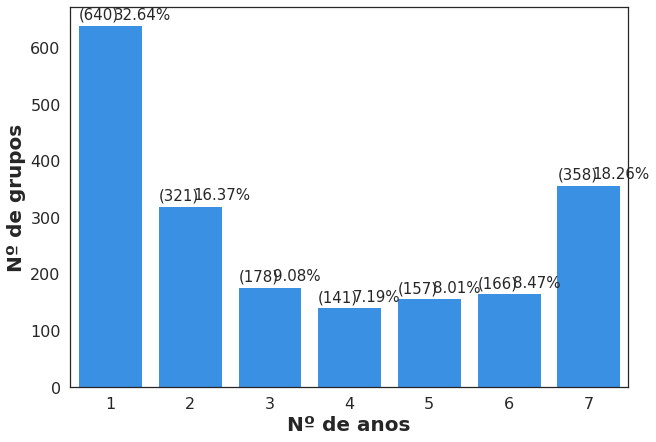

<Figure size 432x288 with 0 Axes>

In [49]:
plot_countplot(combustiveis_years, 'years')

In [50]:
total_items = sum(list(combustiveis_years['n_items']))

In [51]:
total_items

106315.0

In [52]:
sum(list(combustiveis_years[combustiveis_years.years == 4]['n_items']))

1010.0

In [53]:
100*sum(list(combustiveis_years[combustiveis_years.years == 4]['n_items']))/total_items

0.9500070545078305

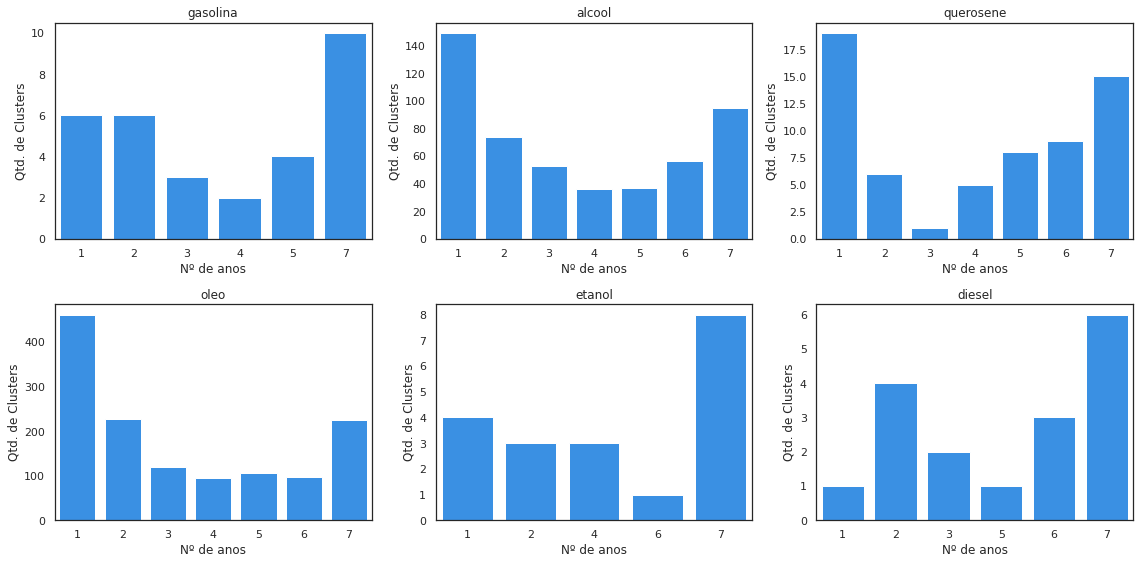

In [54]:
fig, axs = plt.subplots(2, 3, figsize=(16,8))
for ax, termo in zip(axs.flat, combustiveis):
    items_termo = combustiveis_years[combustiveis_years.first_token == termo]
    qtd_clusters = items_termo.drop_duplicates(['cluster', 'dsc_unidade_medida']).groupby("years").apply(lambda clusters: len(clusters))
    sns.barplot(x=qtd_clusters.index, y=qtd_clusters.values, ax=ax, color='dodgerblue')
    ax.set(xlabel="Nº de anos", ylabel="Qtd. de Clusters", title=termo)
fig.tight_layout()
plt.show()

### Quantidade de grupos por ano

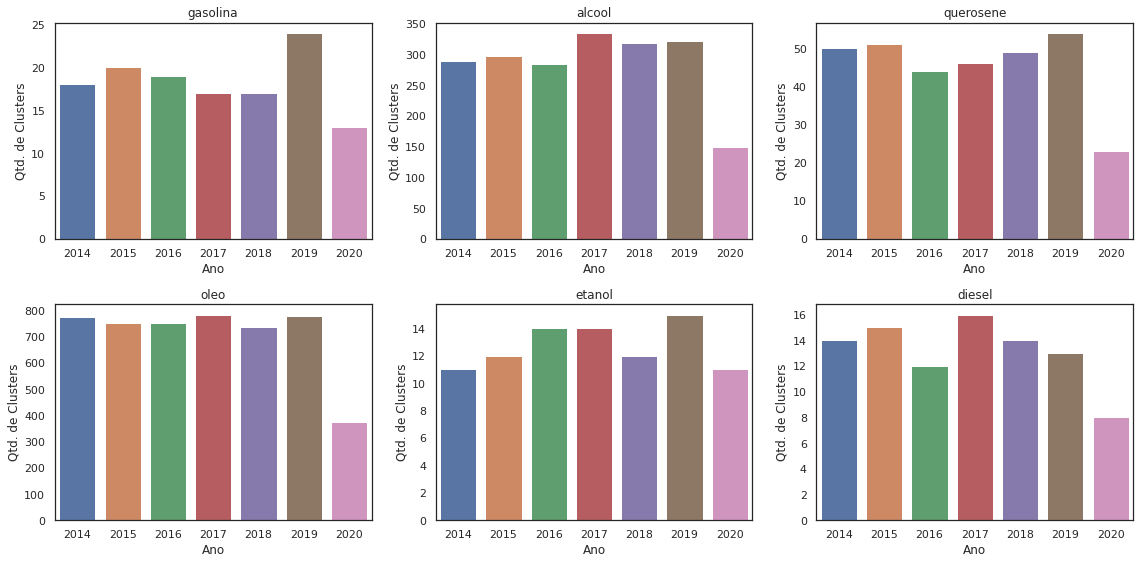

In [55]:
fig, axs = plt.subplots(2, 3, figsize=(16,8))
for ax, termo in zip(axs.flat, combustiveis):
    items_termo = items[items.first_token == termo]
    qtd_clusters = items_termo.drop_duplicates(['cluster', 'dsc_unidade_medida', 'ano']).groupby("ano").apply(lambda clusters: len(clusters))
    sns.barplot(x=qtd_clusters.index, y=qtd_clusters.values, ax=ax)
    ax.set(xlabel="Ano", ylabel="Qtd. de Clusters", title=termo)
fig.tight_layout()
plt.show()

## Hospitais e medicamentos

In [56]:
hospmedicamento_years = clusters_years[clusters_years['first_token'].isin(hospitais_med)]

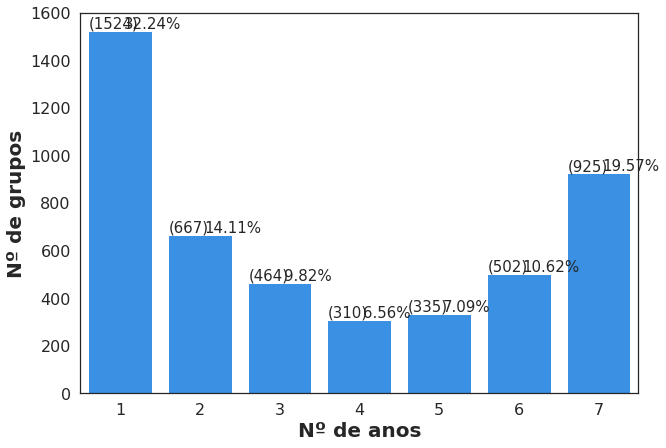

<Figure size 432x288 with 0 Axes>

In [57]:
plot_countplot(hospmedicamento_years, 'years')

In [58]:
total_items = sum(list(hospmedicamento_years['n_items']))

In [59]:
total_items

262637.0

In [60]:
sum(list(hospmedicamento_years[hospmedicamento_years.years == 4]['n_items']))

2163.0

In [61]:
100*sum(list(hospmedicamento_years[hospmedicamento_years.years == 4]['n_items']))/total_items

0.8235701748040071

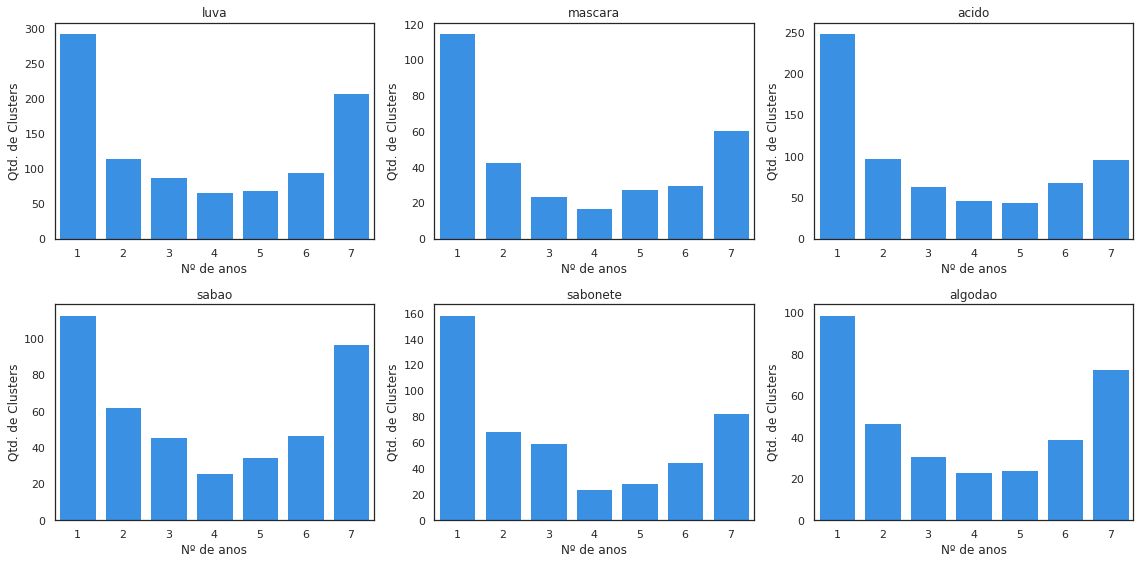

In [62]:
fig, axs = plt.subplots(2, 3, figsize=(16,8))
for ax, termo in zip(axs.flat, hospitais_med):
    items_termo = hospmedicamento_years[hospmedicamento_years.first_token == termo]
    qtd_clusters = items_termo.drop_duplicates(['cluster', 'dsc_unidade_medida']).groupby("years").apply(lambda clusters: len(clusters))
    sns.barplot(x=qtd_clusters.index, y=qtd_clusters.values, ax=ax, color='dodgerblue')
    ax.set(xlabel="Nº de anos", ylabel="Qtd. de Clusters", title=termo)
fig.tight_layout()
plt.show()

### Quantidade de grupos por ano

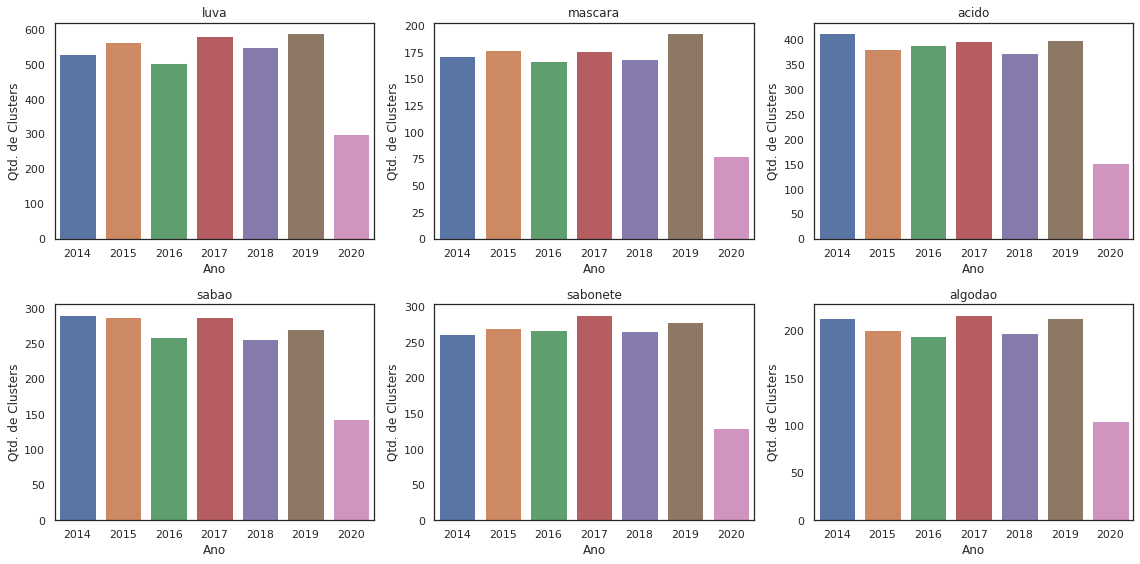

In [63]:
fig, axs = plt.subplots(2, 3, figsize=(16,8))
for ax, termo in zip(axs.flat, hospitais_med):
    items_termo = items[items.first_token == termo]
    qtd_clusters = items_termo.drop_duplicates(['cluster', 'dsc_unidade_medida', 'ano']).groupby("ano").apply(lambda clusters: len(clusters))
    sns.barplot(x=qtd_clusters.index, y=qtd_clusters.values, ax=ax)
    ax.set(xlabel="Ano", ylabel="Qtd. de Clusters", title=termo)
fig.tight_layout()
plt.show()

## Peças e serviços automotivos

In [64]:
pecas_years = clusters_years[clusters_years['first_token'].isin(pecas_automotivos)]

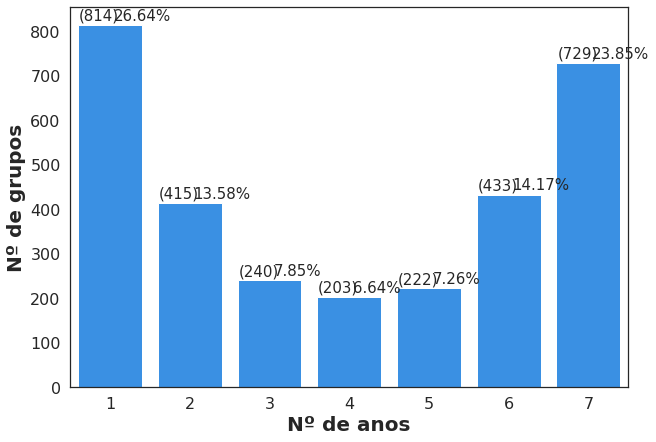

<Figure size 432x288 with 0 Axes>

In [65]:
plot_countplot(pecas_years, 'years')

In [66]:
total_items = sum(list(pecas_years['n_items']))

In [67]:
total_items

351774.0

In [68]:
sum(list(pecas_years[pecas_years.years == 4]['n_items']))

2527.0

In [69]:
100*sum(list(pecas_years[pecas_years.years == 4]['n_items']))/total_items

0.7183589463689756

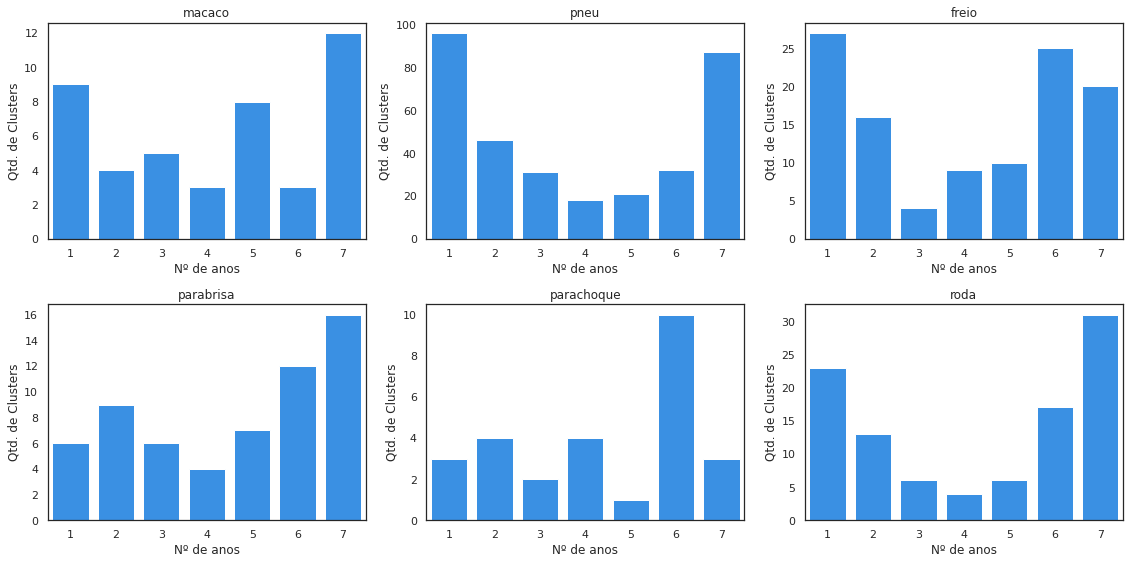

In [70]:
fig, axs = plt.subplots(2, 3, figsize=(16,8))
for ax, termo in zip(axs.flat, pecas_automotivos):
    items_termo = pecas_years[pecas_years.first_token == termo]
    qtd_clusters = items_termo.drop_duplicates(['cluster', 'dsc_unidade_medida']).groupby("years").apply(lambda clusters: len(clusters))
    sns.barplot(x=qtd_clusters.index, y=qtd_clusters.values, ax=ax, color='dodgerblue')
    ax.set(xlabel="Nº de anos", ylabel="Qtd. de Clusters", title=termo)
fig.tight_layout()
plt.show()

### Quantidade de grupos por ano

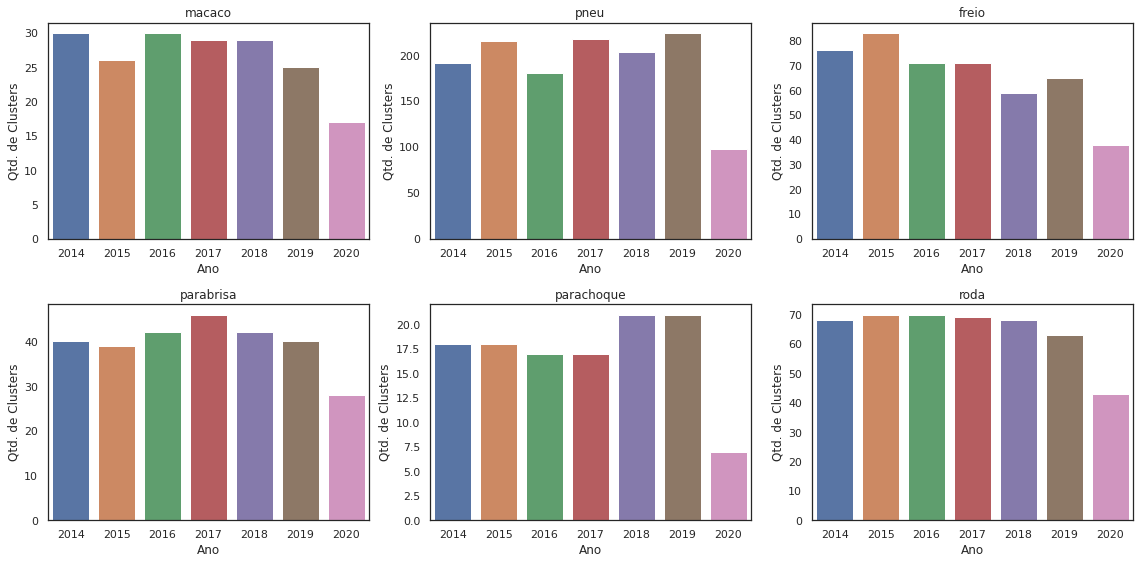

In [71]:
fig, axs = plt.subplots(2, 3, figsize=(16,8))
for ax, termo in zip(axs.flat, pecas_automotivos):
    items_termo = items[items.first_token == termo]
    qtd_clusters = items_termo.drop_duplicates(['cluster', 'dsc_unidade_medida', 'ano']).groupby("ano").apply(lambda clusters: len(clusters))
    sns.barplot(x=qtd_clusters.index, y=qtd_clusters.values, ax=ax)
    ax.set(xlabel="Ano", ylabel="Qtd. de Clusters", title=termo)
fig.tight_layout()
plt.show()

# Variações de preços

## Combustíveis

### Quantidade de itens nos grupos

Clusters de gasolina; | Mínimo: 1 itens | Máximo: 855 itens 
Clusters de alcool; | Mínimo: 1 itens | Máximo: 570 itens 
Clusters de querosene; | Mínimo: 1 itens | Máximo: 51 itens 
Clusters de oleo; | Mínimo: 1 itens | Máximo: 835 itens 
Clusters de etanol; | Mínimo: 1 itens | Máximo: 245 itens 
Clusters de diesel; | Mínimo: 1 itens | Máximo: 161 itens 


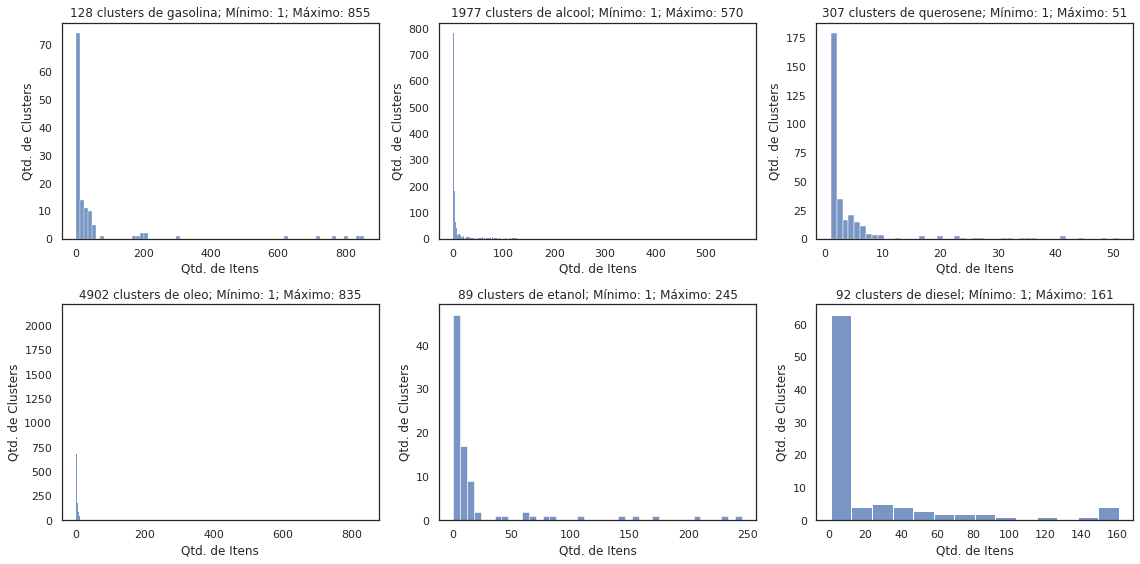

In [72]:
fig, axs = plt.subplots(2, 3, figsize=(16,8))
for ax, termo in zip(axs.flat, combustiveis):
    items_termo = items[items.first_token == termo]
    qtd_itens = items_termo.groupby(["cluster", "dsc_unidade_medida", "ano"]).size()
    print("Clusters de {}; | Mínimo: {} itens | Máximo: {} itens ".format(termo, min(qtd_itens), max(qtd_itens)))
    sns.histplot(x=qtd_itens, ax=ax)
    ax.set(xlabel="Qtd. de Itens", ylabel="Qtd. de Clusters", title="{} clusters de {}; Mínimo: {}; Máximo: {}".format(len(qtd_itens),termo, min(qtd_itens), max(qtd_itens)))
fig.tight_layout()
plt.show()    

### Variações de preço dos grupos

/dados01/workspace/ufmg.f01dcc/py37/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/dados01/workspace/ufmg.f01dcc/py37/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/dados01/workspace/ufmg.f01dcc/py37/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inste

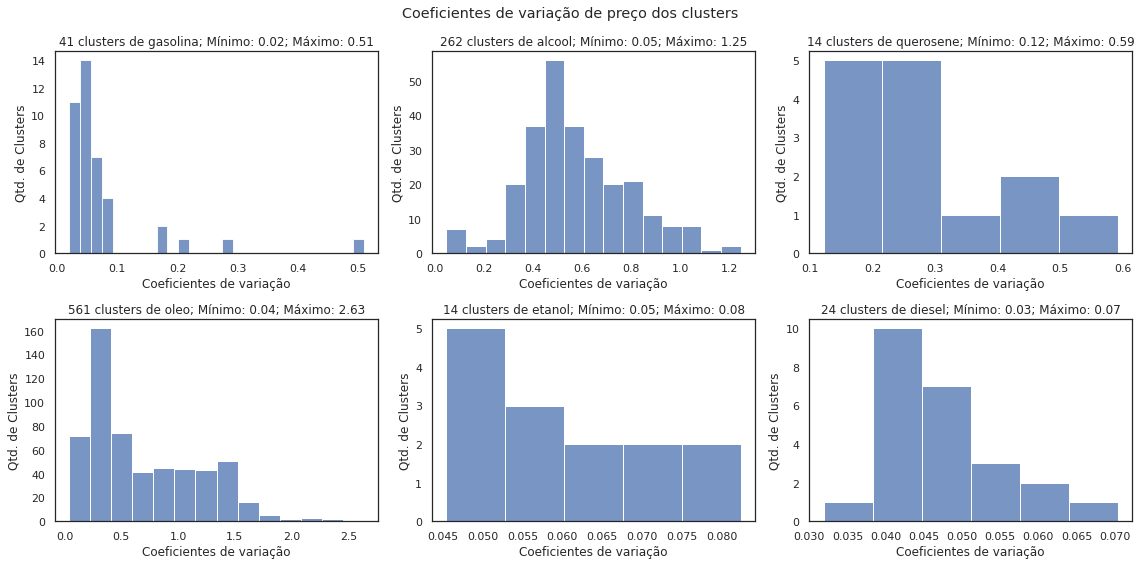

In [73]:
fig, axs = plt.subplots(2, 3, figsize=(16,8))
for ax, termo in zip(axs.flat, combustiveis):
    clusters_termo = prices[(prices.first_token == termo) & (prices.n_items >= 20)]
    cv = clusters_termo["std"] / clusters_termo["mean"]
    clusters_termo['cv'] = cv
    sns.histplot(data = clusters_termo, x='cv', ax=ax, multiple="dodge")
    ax.set(xlabel="Coeficientes de variação", ylabel="Qtd. de Clusters", title="{} clusters de {}; Mínimo: {:.2f}; Máximo: {:.2f}".format(len(clusters_termo),termo, min(cv), max(cv)))
fig.suptitle("Coeficientes de variação de preço dos clusters")
fig.tight_layout()
plt.show()

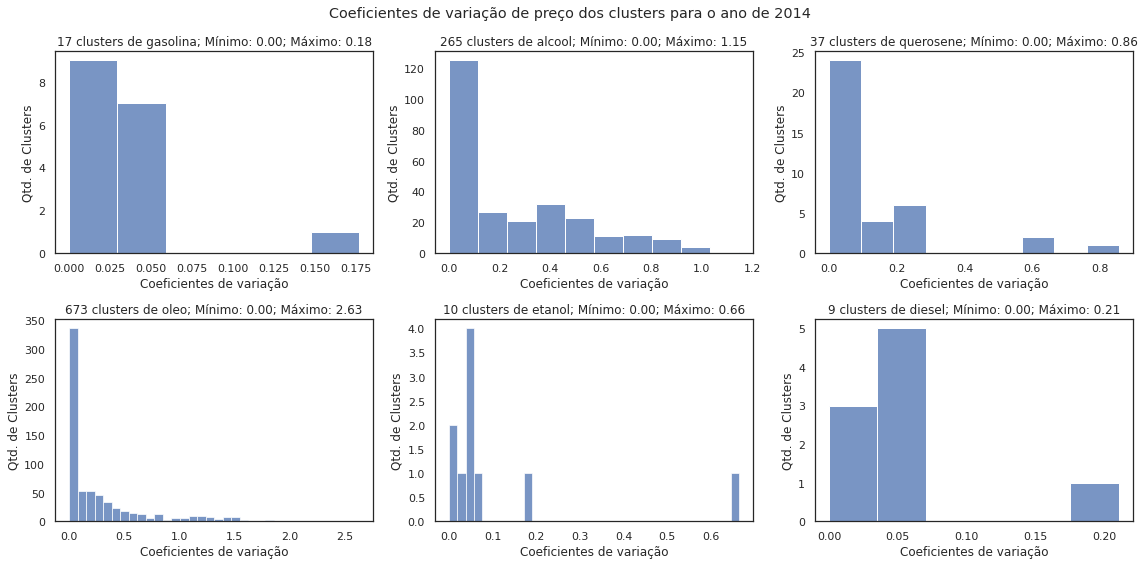

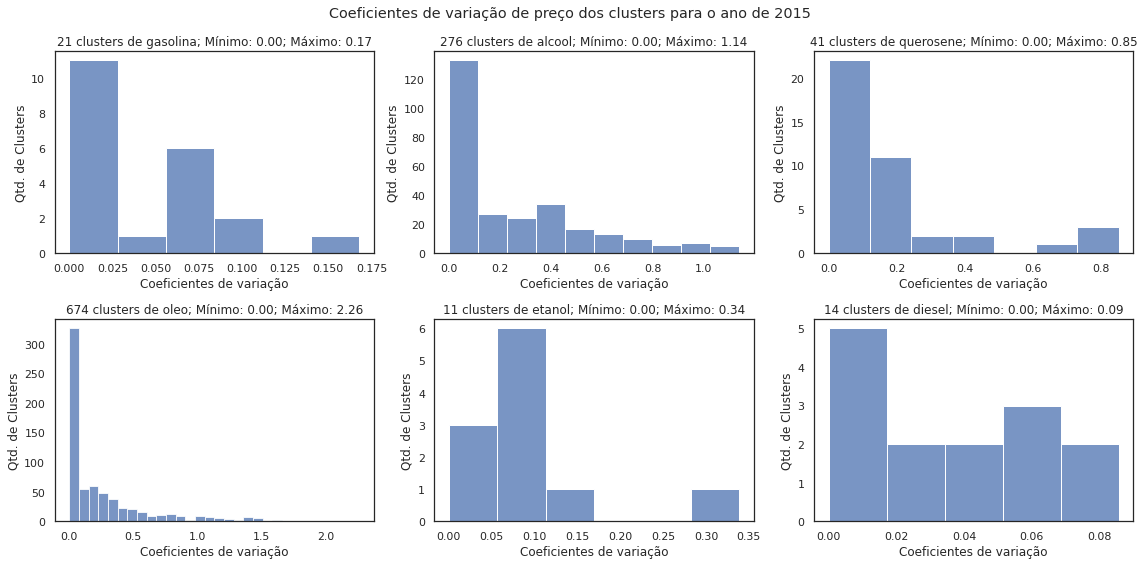

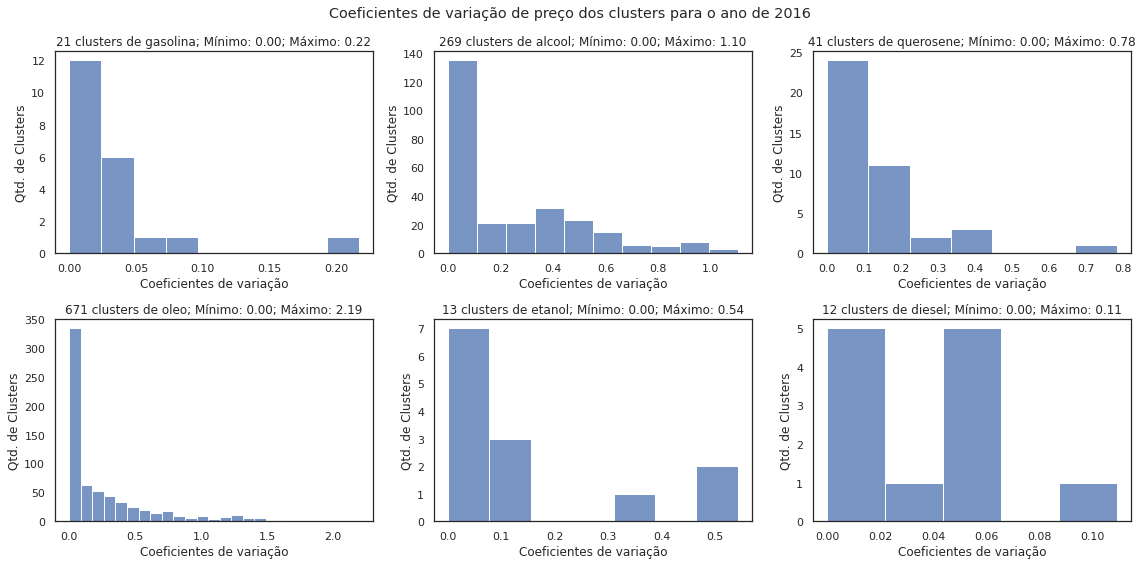

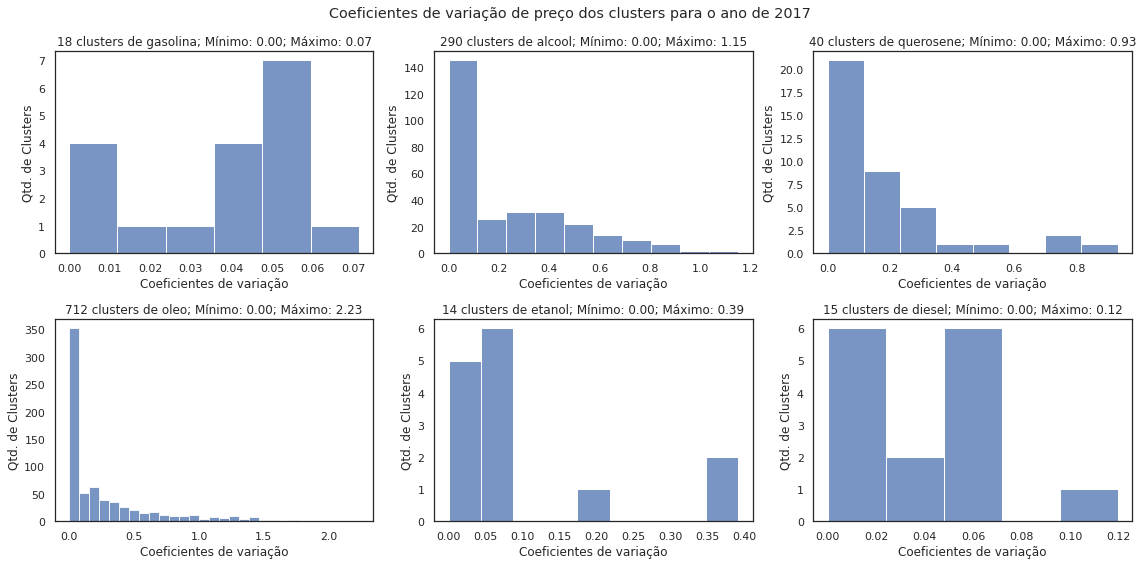

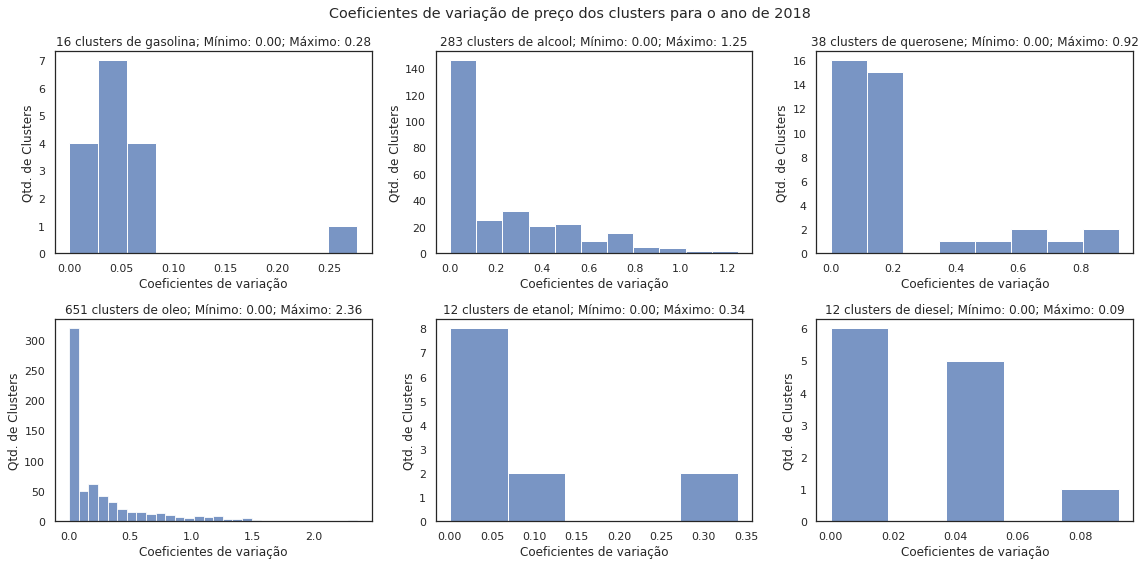

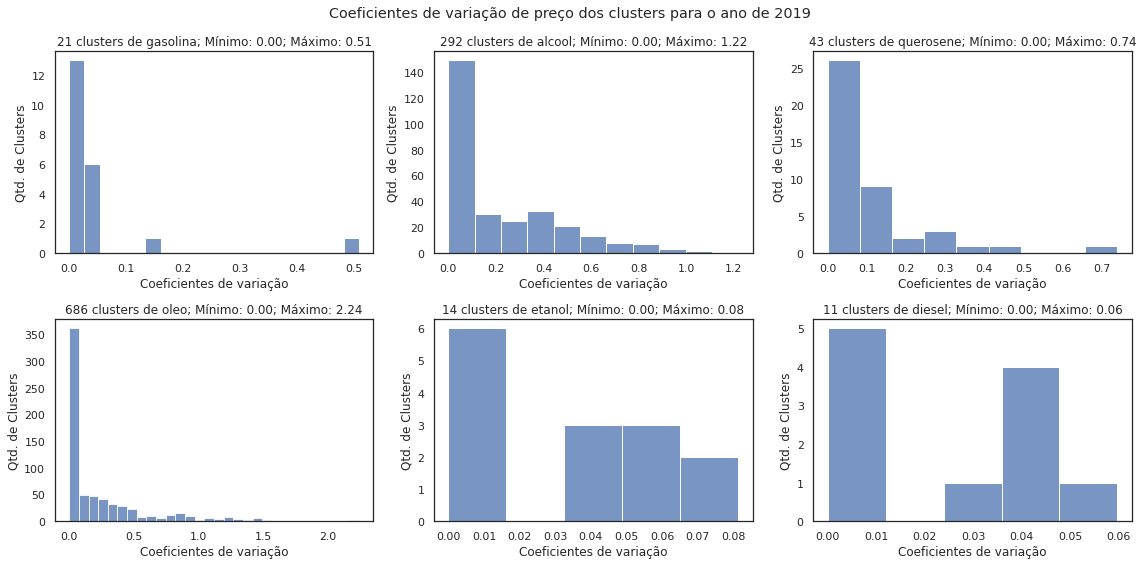

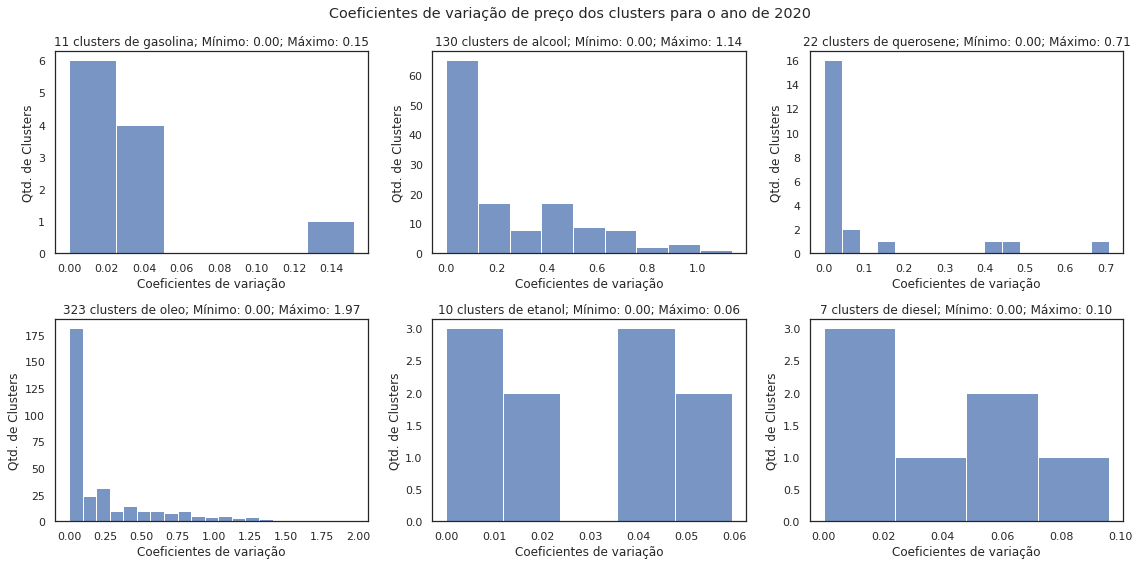

In [74]:
for ano in np.sort(prices.ano.unique()):
    fig, axs = plt.subplots(2, 3, figsize=(16,8))
    for ax, termo in zip(axs.flat, combustiveis):
        clusters_termo = prices[(prices.first_token == termo) & (prices.ano == ano)]
#         unidade = "litro"
#         clusters_termo = clusters_termo[clusters_termo.dsc_unidade_medida == unidade]
        cv = clusters_termo["std"] / clusters_termo["mean"]
        sns.histplot(x=cv, ax=ax)
        ax.set(xlabel="Coeficientes de variação", ylabel="Qtd. de Clusters", title="{} clusters de {}; Mínimo: {:.2f}; Máximo: {:.2f}".format(len(clusters_termo),termo, min(cv), max(cv)))
    fig.suptitle("Coeficientes de variação de preço dos clusters para o ano de {}".format(ano))
    fig.tight_layout()
    plt.show()

## Hospitais e medicamentos

### Quantidade de itens nos grupos

Clusters de luva; | Mínimo: 1 itens | Máximo: 2829 itens 
Clusters de mascara; | Mínimo: 1 itens | Máximo: 708 itens 
Clusters de acido; | Mínimo: 1 itens | Máximo: 362 itens 
Clusters de sabao; | Mínimo: 1 itens | Máximo: 256 itens 
Clusters de sabonete; | Mínimo: 1 itens | Máximo: 346 itens 
Clusters de algodao; | Mínimo: 1 itens | Máximo: 251 itens 


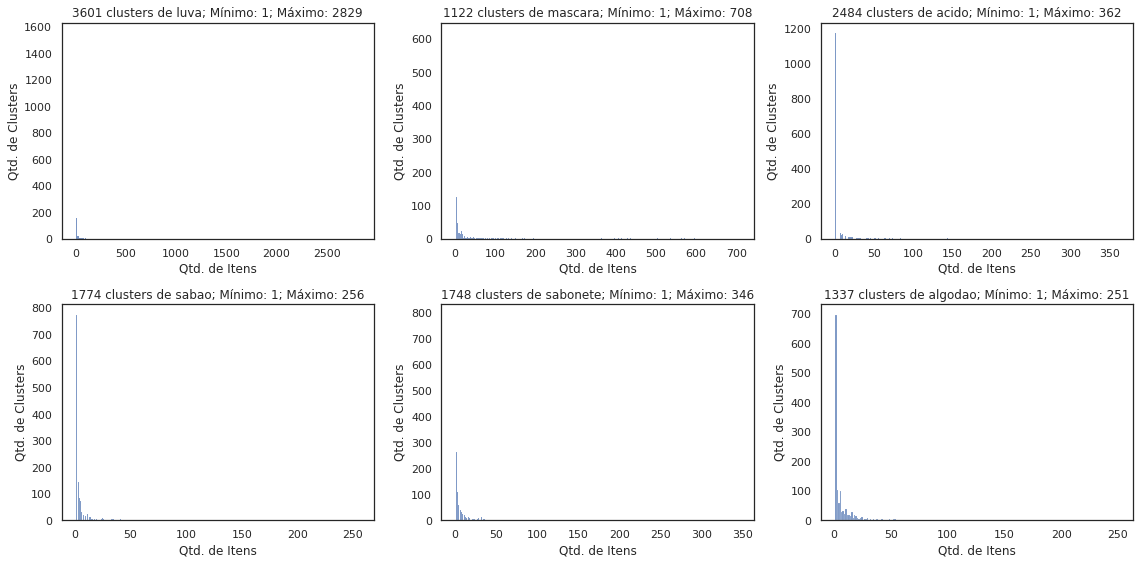

In [75]:
fig, axs = plt.subplots(2, 3, figsize=(16,8))
for ax, termo in zip(axs.flat, hospitais_med):
    items_termo = items[items.first_token == termo]
    qtd_itens = items_termo.groupby(["cluster", "dsc_unidade_medida", "ano"]).size()
    print("Clusters de {}; | Mínimo: {} itens | Máximo: {} itens ".format(termo, min(qtd_itens), max(qtd_itens)))
    sns.histplot(x=qtd_itens, ax=ax)
    ax.set(xlabel="Qtd. de Itens", ylabel="Qtd. de Clusters", title="{} clusters de {}; Mínimo: {}; Máximo: {}".format(len(qtd_itens),termo, min(qtd_itens), max(qtd_itens)))
fig.tight_layout()
plt.show()    

### Variação de preço dos grupos

/dados01/workspace/ufmg.f01dcc/py37/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/dados01/workspace/ufmg.f01dcc/py37/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/dados01/workspace/ufmg.f01dcc/py37/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inste

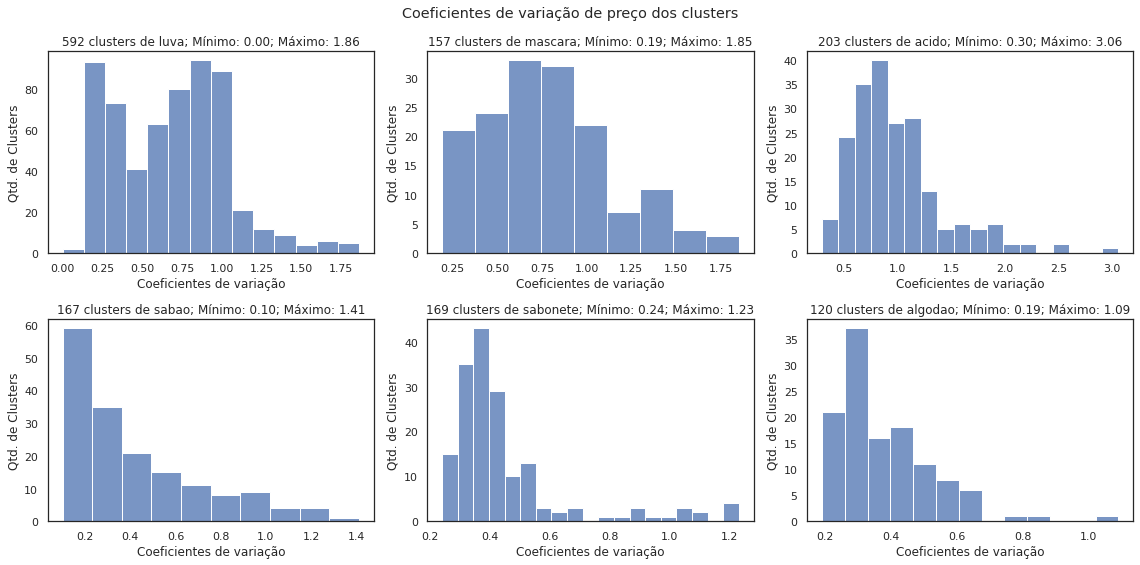

In [76]:
fig, axs = plt.subplots(2, 3, figsize=(16,8))
for ax, termo in zip(axs.flat, hospitais_med):
    clusters_termo = prices[(prices.first_token == termo) & (prices.n_items >= 20)]
    cv = clusters_termo["std"] / clusters_termo["mean"]
    clusters_termo['cv'] = cv
    sns.histplot(data = clusters_termo, x='cv', ax=ax, multiple="dodge")
    ax.set(xlabel="Coeficientes de variação", ylabel="Qtd. de Clusters", title="{} clusters de {}; Mínimo: {:.2f}; Máximo: {:.2f}".format(len(clusters_termo),termo, min(cv), max(cv)))
fig.suptitle("Coeficientes de variação de preço dos clusters")
fig.tight_layout()
plt.show()

## Peças e serviços automotivos

### Quantidade de itens nos grupos

Clusters de macaco; | Mínimo: 1 itens | Máximo: 54 itens 
Clusters de pneu; | Mínimo: 1 itens | Máximo: 5195 itens 
Clusters de freio; | Mínimo: 1 itens | Máximo: 126 itens 
Clusters de parabrisa; | Mínimo: 1 itens | Máximo: 122 itens 
Clusters de parachoque; | Mínimo: 1 itens | Máximo: 50 itens 
Clusters de roda; | Mínimo: 1 itens | Máximo: 65 itens 


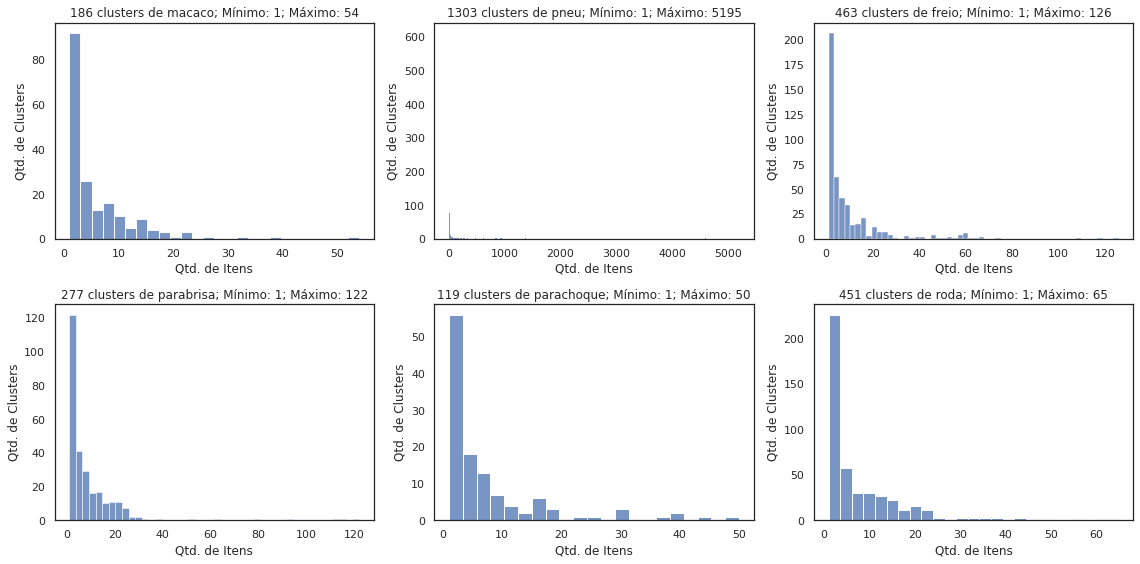

In [77]:
fig, axs = plt.subplots(2, 3, figsize=(16,8))
for ax, termo in zip(axs.flat, pecas_automotivos):
    items_termo = items[items.first_token == termo]
    qtd_itens = items_termo.groupby(["cluster", "dsc_unidade_medida", "ano"]).size()
    print("Clusters de {}; | Mínimo: {} itens | Máximo: {} itens ".format(termo, min(qtd_itens), max(qtd_itens)))
    sns.histplot(x=qtd_itens, ax=ax)
    ax.set(xlabel="Qtd. de Itens", ylabel="Qtd. de Clusters", title="{} clusters de {}; Mínimo: {}; Máximo: {}".format(len(qtd_itens),termo, min(qtd_itens), max(qtd_itens)))
fig.tight_layout()
plt.show()    

### Variação de preço dos grupos

In [ ]:
fig, axs = plt.subplots(2, 3, figsize=(16,8))
for ax, termo in zip(axs.flat, pecas_automotivos):
    clusters_termo = prices[(prices.first_token == termo) & (prices.n_items >= 20)]
    cv = clusters_termo["std"] / clusters_termo["mean"]
    clusters_termo['cv'] = cv
    sns.histplot(data = clusters_termo, x='cv', ax=ax, multiple="dodge")
    ax.set(xlabel="Coeficientes de variação", ylabel="Qtd. de Clusters", title="{} clusters de {}; Mínimo: {:.2f}; Máximo: {:.2f}".format(len(clusters_termo),termo, min(cv), max(cv)))
fig.suptitle("Coeficientes de variação de preço dos clusters")
fig.tight_layout()
plt.show()

/dados01/workspace/ufmg.f01dcc/py37/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/dados01/workspace/ufmg.f01dcc/py37/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/dados01/workspace/ufmg.f01dcc/py37/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inste